In [1]:
import skimage.io as io
import pandas as pd
import os
import matplotlib.pyplot as plt
example_root = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'examples')

## pcnaDeep: Getting Started

### Author: Yifan Gui @ Kuan Yoow Chan group

__Welcome!__ pcnaDeep is a four-stage model that profiles the cell cycle, including:

- Instance segmentation _(Detectron2's Mask R-CNN)_
- Cell tracking _(TrackPy)_
- Mitosis association
- Cell cycle resolving

Check the [Manuscript and its Supplementary Material](https://www.biorxiv.org/content/10.1101/2021.09.19.460933) for detailed descriptions.

__Installation guide__ is available on our [GitHub main page](https://github.com/chan-labsite/PCNAdeep).

![Overview](assets/overview.jpg)

---

Below we use a demo stack from images of MCF10A to illustrate the pipeline.

### __Frist, please download [Pretrained Mask R-CNN model (351 MB)](https://zenodo.org/record/5515771/files/mrcnn_sat_rot_aug.pth?download=1) and [demo data (328 MB)](https://zenodo.org/record/5515771/files/demo.rar?download=1).__

__The Mask R-CNN model should be saved under `~/models/` and demo data under `~/examples/`__

### 1 Quick Demo Run

To run pcnaDeep demo, navigate to `bin` and call the `main.py` script with the following commands. Make sure GPU is available. 

`
python main.py --pcna ../examples/demo/MCF10A_demo_PCNA.tif --bf ../examples/demo/MCF10A_demo_BF.tif --pcna-config ../config/pcnaCfg.yaml --dtrn-config ../config/dtrnCfg.yaml --output ../examples/demo/testing --opts MODEL.WEIGHTS ../models/mrcnn_sat_rot_aug.pth
`

---

We disect the input arguments and output files in the following sections.

### 2 Input

pcnaDeep takes __`uint16`__ time-lapse image stack inputs from __two channels__: PCNA fluorescent (__FL__) and the bright field (__BF__).  
This is specified through __`--pcna`__ and __`--bf`__.

___Caution___: The model is trained on __60X confocal images sized 1200X1200 pixel__ (1.83um/pixel). It is not recommanded to use images that have large difference in size for the pretrained model. However, it is practical to train on your own data (see tutorial [here](train_pcna_detectron2.ipynb)) or perform multi-scale training to fit your specific task.

We inspect these images as below.

In [2]:
pcna = io.imread(os.path.join(example_root, 'demo', 'MCF10A_demo_PCNA.tif'))
bf = io.imread(os.path.join(example_root, 'demo', 'MCF10A_demo_BF.tif'))
assert pcna.shape == bf.shape
print(pcna.shape)

(135, 1200, 1200)


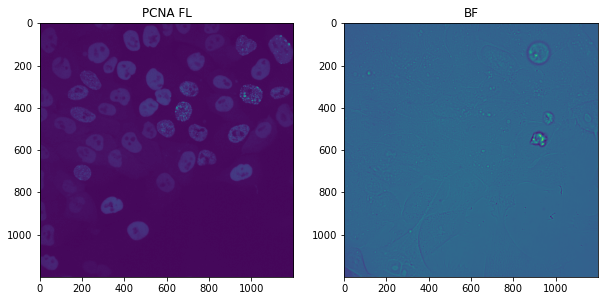

In [3]:
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].set_title('PCNA FL')
axes[1].set_title('BF')
axes[0].imshow(pcna[0,:,:])
axes[1].imshow(bf[0,:,:])

The pixel intensity level of raw images does not cover the full range, therefore raw images are scaled during rum-time. Since Mask R-CNN does prediction on 3-channel RGB images, the PCNA FL and BF channels are stacked, with PCNA FL repeated once.

pcnaDeep uses `pcnaDeep.data.utils.getDetectInput` for this pre-processing step, using __`PIX_SATURATE`__ and __`GAMMA`__ in the __pcnaDeep config file__ (see comments in [config reference](pcna_config_ref.ipynb)).
- `PIX_SATURATE`: __Saturation percentage__ of the pixel intensity level. If set to 1 by default, 1% of the lowest and highest pixel intensity will be cropped. That is, 1% lowest set to 0 while 1% highest set to 255 in the `uint8` format.
- `GAMMA`: __Gamma correction factor__. By default, pcnaDeep does not perform any gamma correction, i.e, `gamma=1`

This step will convert `uint16` raw input to `uint8` images for downstream processing.

In [4]:
from pcnaDeep.data.utils import getDetectInput
comp = getDetectInput(pcna, bf, gamma=1, sat=1)

Saturation: 1, Gamma 1
Shape:  (135, 1200, 1200, 3)


We save the output image to file for other tutorials (556MB).

In [5]:
io.imsave(os.path.join(example_root, 'demo', 'MCF10A_demo_comp.tif'), comp)

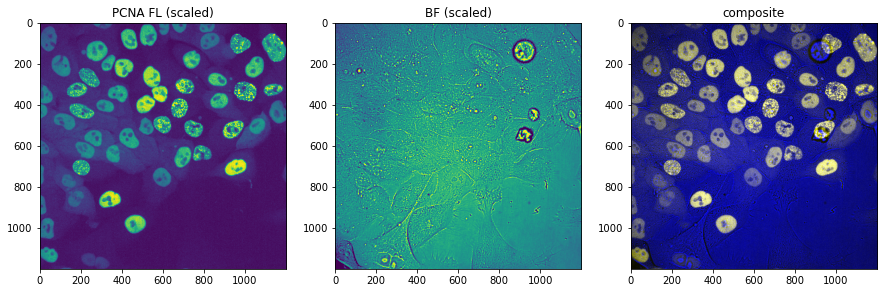

In [6]:
fig, axes = plt.subplots(1,3, figsize=(15,15))
axes[0].set_title('PCNA FL (scaled)')
axes[1].set_title('BF (scaled)')
axes[2].set_title('composite')
axes[0].imshow(comp[0,:,:,0])
axes[1].imshow(comp[0,:,:,2])
axes[2].imshow(comp[0,:,:,:])

On top of parameters for image input and pre-processing, the command also specifies two config files `--pcna-cfg` and `--dtrn-cfg`:

- __`--pcna-cfg`__: For configuring parameters involved in pcnaDeep main function. Default `~/config/pcnaCfg.yaml`.

    _(pcnaDeep configs are discussed in the below section.)_


- __`--dtrn-cfg`__: For configuring Detectron2's Mask R-CNN model, see config reference [here](). Default `~/config/dtrnCfg.yaml`. In the command above, we use __`--opts MODEL.WEIGHT`__ to change Detectron2 config and specify the pre-trained model.


- __`--confidence-threshold`__: Change Detectron2 Mask R-CNN detection confidence threshold through commandline. Default 0.5.

Finally, the output directory should be specified through __`--output`__.

---

### 3 Adjust Default Configs

In __`pcnaCfg.yaml`__, here are important parameters the user is suggested to change for his/her own datasets __before the first trial__.  These parameters are either imaging condition-specific or cell type-specific. However, if you are unsure about how to adjust, it is always fine to try with defaults.

- The metadata
    - `SAMPLE_FREQ` Change to the sampling frequency of the video, in the unit of _frame per minute_.
    
- pcnaDeep uses thresholding to associate spatial-temporal correlated mitosis mother and daughters.
    
    - `MAX_DIST_TRH` (_the distance threshold_) Change to the largest allowed pixel distance between mother and daughter tracks in mitosis.
    - `MAX_FRAME_TRH` (_the frame threshold_) Change to the largest allowed frame distance between mother's disappearance and daughter's appearance.  
    _(a supervised SVM method is also implemented but did not perform well in our experiments. See specific tutorials at page bottom.)_

- TrackPy parameters
    - `DISPLACE` Change to the largest allowed object movement in pixel unit. Since pcnaDeep tracks object in a 4D feature space, the parmeter should not be set to a very small value as in a x-y space. Our emperical setting is around one cell's diameter.
    - `GAP_FILL` Change to the largest frame gap allowed in one track.

Here are the parameters the user may change to fine-tune the pipeline __after the first trial__.
- `EDGE_FLT` Filter out objects at the edge as their cell cycle may not be precisely classified (imagine an S-exit cell that show no foci in the field of view).
- `SIZE_FLT` Filter out small objects (e.g. cell debris), in pixel square unit.
- `MAX_BG` In Greedy Phase Searching algorithm, set to largest allowed background label appearance - 1 for searching target phase. The minus one is because the algorithm is operating on confidence score smaller than one. That is to say, if you believe Mask R-CNN will not output 6 consecutive faulty classifications, you can set the threshold to 5.
- `MIN_S, MIN_M` In Greedy Phase Searching algorithm, set to smallest targeted phase label appearance - 1 for searching S/M, respectively. The rationale for calibrating these parameters is the same as above.

Other parameters are explained in the [config reference](pcna_config_ref.ipynb).

---

A second way of adjusting parameters is to scale them according to your sampling frequency. That is to say, scale default time-related parameters to a half if you use `SAMPLE_FREQ = 0.1` (default 0.2), including `GAP_FILL, MAX_BG, MIN_S, MIN_M, SMOOTH, SEARCH_RANGE, MAX_FRAME_TRH, MIN_LINEAGE`. 
For distance-related ones including `DISPLACE, MAX_DIST_TRH`, our experience is not to incrase too much because cell movement does not increase proportionally; 1.5 times is fine for doubled sampling frequency.

---

In __`dtrnCfg.yaml`__, the image size is currently set to `1200~2048` pixel. You may change the followng setting to fit your own experiment.
- `INPUT.MAX_SIZE_TEST = 2048`, `INPUT.MIN_SIZE_TEST = 1200`.

---

### 4 Output

The entire pipeline of pcnaDeep outputs __four tables and the cell nucleus mask__.

- The __`_tracks_refined.csv`__ is the most important output referred as __tracked object table__.
- The __`_phase.csv`__ records cell cycle phase information in the tracks referred as __phase table__.
- The __`_tracks.csv`__ recordes unresolved tracks and __`_tracks_ann.csv`__ records track metadata. These two table are mainly used for debugging.

#### Tracked object table

In [7]:
tracks = pd.read_csv(os.path.join(example_root, 'demo', 'testing', 'MCF10A_demo_tracks_refined.csv'))
tracks.iloc[0:5,:]

,frame,trackId,lineageId,parentTrackId,Center_of_the_object_1,Center_of_the_object_0,predicted_class,Probability of G1/G2,Probability of S,Probability of M,continuous_label,major_axis,minor_axis,mean_intensity,emerging,background_mean,BF_mean,BF_std,resolved_class
0,0,1,1,0,12.786237,306.448602,G1/G2,0.987485,0.003339,0.003104,1,94.857803,33.434676,65.535054,0,21.264633,100.912258,100.912258,G1*
1,1,1,1,0,11.821749,311.677541,G1/G2,0.987846,0.002805,0.003374,1,92.924259,31.024087,64.373050,0,20.947015,96.698345,96.698345,G1*
2,2,1,1,0,14.087873,315.990060,G1/G2,0.993086,0.002397,0.001691,1,93.731589,36.377008,75.036581,0,20.445887,100.809543,100.809543,G1*
3,3,1,1,0,14.332696,315.752964,G1/G2,0.995264,0.001989,0.001109,1,95.994787,36.818030,67.778585,0,20.572007,99.287954,99.287954,G1*
4,4,1,1,0,14.545693,316.967041,G1/G2,0.997404,0.001637,0.000482,1,96.657960,37.142564,70.597378,0,20.561380,104.335581,104.335581,G1*


Each row in the table corresponds to one object. The important fields are:

- __`Frame, Center_of_the_object_0, Center_of_the_object_1`__: The 3D location of the object, corresponding to time, x and y coordinate.
- __`trackId, lineageId, parentTrackId`__: Every individual track has its own `trackId`. `lineageId` refers to the most ancenstry cell that the cell is divided from. `parentTrackId` refers to the direct mother of the cell, 0 if no mother.
- __`predicted_class, resolved_class`__: The first field contains morphological labels from Mask R-CNN output while the second for resolved cell cycle phase.
    - Resolved class with a star like __"G1\*"__ means the cell is arrested in G1. The G1 is distinguished from G2 using user specified intensity threshold in `pcnaCfg.yaml` - `G2_TRH`. The intensity level should be background-subtracted. Over-threshold tracks will be classified as __"G2\*"__. 
    - Resolved class marked with __G1/G2__ corresponds to tracks that failed to be resolved. See below _Runtime Logging_ section for details.
- __`continuous_label`__: corresponds to values labeled in the cell nueleus mask.

#### Phase table

In [8]:
phase = pd.read_csv(os.path.join(example_root, 'demo', 'testing', 'MCF10A_demo_phase.csv'))
phase.iloc[0:5,:]

,track,type,length,lin_length,arrest,G1,S,M,G2,parent,imprecise_exit
0,1,arrest-G1,135,135,135.0,NaN,NaN,NaN,NaN,0,0
1,2,normal,135,135,NaN,NaN,>103,NaN,>32,0,0
2,3,arrest-G1,20,20,20.0,NaN,NaN,NaN,NaN,0,0
3,4,normal,135,135,NaN,>25,>110,NaN,NaN,0,0
4,5,normal,135,135,NaN,NaN,>86,NaN,>49,0,0


The track ID is recorded in `track` column. Arrested tracks are annotated with `arrest-phase` in `type` column.

Cell cycle phase durations are indicated. If the detected phase is incomplete, it is annotated with `>` (e.g. `>42`), showing tracked length.

Importantly, the __`imprecise_exit`__ indicates the mitosis exit of the daughter cell is not preciesly detected, because no M label has been asigned to the track. The daughter is associated with its mother through E label, and the mitosis length is calculated by assuming the first appearance of the track is mitosis exit.

---

### The Runtime Logging

Most of the information in the runtime logging and output `log.txt` is for debugging.  
However, there are __three kinds of rare warnings__ the user must pay attention to.

- The first indicates consecutive mitosis without S phase in between. The entire lineage will not be resolved.

__&emsp;&emsp;&emsp;`pcna.Resolver WARNING: Sequential mitosis without S phase; Ignore tracks: 1,2,3`__

- The second indicates >20% phase difference after resolving, compared with morphological labels.

__&emsp;&emsp;&emsp;`pcna.Resolver WARNING: Numerous classification change after resolving, check: 10,11`__

- The third indicates biologically invalid phase transitions.

__&emsp;&emsp;&emsp;`pcna.Resolver WARNING: Wrong transition S-M in track: 12`__

Both of the warnings may result from tracking and detection errors. According to the reported __`trackId`__, the user is suggested to check the above output tables or to exclude these tracks from any further analysis.

---

### 5 Visualisation

The __tracked object table__ is directly importable into __Fiji__ through __[TrackMate CSV Importer](https://github.com/tinevez/TrackMate-CSVImporter)__ (installation required).

1. Load `MCF10A_demo_PCNA.tif` to Fiji through dragging it to the tool bar or __File > Open__. Enhance the contrast if required. 

&emsp; &emsp;You may also use the composite image generated in the above __Step 2__.


2. Invert t and z axis of the image if necessary, through __Image > Properties__. 

&emsp; &emsp; In this example, set _frame (t)_ to 66 and _slice (z)_ to 1.


3. Open TrackMate CSV Importer through __Plugin > Tracking > TrackMate CSV Importer__.

4. Config parameters as the following (see screenshot below):
    <img src="assets/vis_guide_0.png"  alt="config trackmate csv importer" width=800/>
    
    - Compute all features? = unchecked; Import tracks? = tracked
    - Radius: choose one comfortable to the cell size, in this case is 50 pixels
    - __X/Y column: Center_of_the_object_0/1__
    - __Z column: "Don't use"__
    - Frame column: frame
    - Track column: trackId
    - Name column: name
    - Quality column & ID column: "Don't use"
    
    
5. Click 'Import', and then adjust GUI
    - check "Display spot names"
    - under "Track display mode", choose "Show local tracks"
    
Each object is labeled with its "name", which is __`trackId-(parentTrackId)-resolved phase`__.

---

In [2]:
from pyversions import versions
import skimage
versions();

Darwin 21.2.0 64-bit Darwin Kernel Version 21.2.0: Sun Nov 28 20:28:54 PST 2021; root:xnu-8019.61.5~1/RELEASE_X86_64
CPython 3.7.9 (default, Aug 31 2020, 07:22:35) [Clang 10.0.0 ]
Jun 09 2022, 16:45:19

Module           Version
ipython           7.27.0
jupyterlab        3.0.10
matplotlib         3.4.2
notebook           6.4.0
numpy             1.18.5
pandas             1.2.4
pyversions         0.0.3
skimage           0.17.2


---

### Specific Tutorials (advanced usage explained)

1. [Train Detectron2 Mask R-CNN model](train_pcna_detectron2.ipynb)  

2. [Evaluate with Cell Tracking Challenge Matrices](evaluation_with_CTC.ipynb)

3. [Run in batch](run_in_batch.ipynb)

4. [Hack in intermediate stages](hack_in.ipynb)

5. [Train an SVM classifier for mitosis association (__experimental__)](train_pcna_SVM.ipynb)  

6. [Manual correction](correction_interface.ipynb)

__Example data for tutorial 1__: [download RPE.rar (41 MB)](https://zenodo.org/record/5515771/files/RPE.rar?download=1).

__Example data for tutorial 2 & 5__: [download MCF10A.rar (368 MB)](https://zenodo.org/record/5515771/files/MCF10A.rar?download=1).

__Example data for tutorial 4 (Size: 6 MB)__: [download intermediate.rar (6 MB)](https://zenodo.org/record/5515771/files/intermediate.rar?download=1).

_Remember_ to save data under `~/examples/`.